In [ ]:
# Configuration initiale
#Installez les dépendances nécessaires
!pip install pyspark lightgbm matplotlib seaborn pandas numpy scikit-learn
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Installer les dépendances nécessaires
!pip install notebook

# Lancer un serveur Jupyter
!jupyter notebook --ip=0.0.0.0 --port=8888 --no-browser --allow-root --NotebookApp.allow_origin='https://colab.research.google.com'

|DEBUG|Paths used for configuration of jupyter_notebook_config: 
    	/etc/jupyter/jupyter_notebook_config.json
|DEBUG|Paths used for configuration of jupyter_notebook_config: 
    	/usr/local/etc/jupyter/jupyter_notebook_config.d/ipyparallel.json
    	/usr/local/etc/jupyter/jupyter_notebook_config.d/panel-client-jupyter.json
    	/usr/local/etc/jupyter/jupyter_notebook_config.json
|DEBUG|Paths used for configuration of jupyter_notebook_config: 
    	/usr/etc/jupyter/jupyter_notebook_config.json
|DEBUG|Paths used for configuration of jupyter_notebook_config: 
    	/root/.local/etc/jupyter/jupyter_notebook_config.json
|DEBUG|Paths used for configuration of jupyter_notebook_config: 
    	/root/.jupyter/jupyter_notebook_config.json

  _   _          _      _
 | | | |_ __  __| |__ _| |_ ___
 | |_| | '_ \/ _` / _` |  _/ -_)
  \___/| .__/\__,_\__,_|\__\___|
       |_|
                       
Read the migration plan to Notebook 7 to learn about the new features and the actions to take if you 

In [ ]:
# Vérifier la structure du projet
!find . -type f | sort

In [ ]:
%run /content/drive/MyDrive/mmm-ecommerce/scripts/download_data.py

Chargement du fichier Excel...
Dimensions du dataset: (541909, 8)
Premières lignes:
  InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

          InvoiceDate  UnitPrice  CustomerID         Country  
0 2010-12-01 08:26:00       2.55     17850.0  United Kingdom  
1 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
2 2010-12-01 08:26:00       2.75     17850.0  United Kingdom  
3 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
4 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
Conversion en CSV...
Conversion terminée : data/Online_Retail.csv


# Exploration des données Online Retail

Cette partie explore le jeu de données Online Retail disponible sur Kaggle pour la modélisation MMM.


In [ ]:
# Importer les bibliothèques nécessaires
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql import SparkSession
import os
import sys
# Configuration de Matplotlib
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 7)
plt.rcParams['font.size'] = 12

# Ajouter le répertoire parent au chemin Python
sys.path.append('..')

In [ ]:
# Initialiser une session Spark
spark = SparkSession.builder \
    .appName("online_retail_exploration") \
    .config("spark.driver.memory", "4g") \
    .getOrCreate()

print(f"Spark version: {spark.version}")

Spark version: 3.5.5


In [ ]:
# Charger les données
retail_path = "/content/mmm-ecommerce/data/Online_Retail.csv"
retail_df = spark.read.csv(retail_path, header=True, inferSchema=True)

# Afficher le schéma
print("Schéma des données:")

retail_df.printSchema()
# Aperçu des données
print("\nAperçu des données:")
retail_df.show(5)

Schéma des données:
root
 |-- InvoiceNo: string (nullable = true)
 |-- StockCode: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- Quantity: integer (nullable = true)
 |-- InvoiceDate: timestamp (nullable = true)
 |-- UnitPrice: double (nullable = true)
 |-- CustomerID: double (nullable = true)
 |-- Country: string (nullable = true)


Aperçu des données:
+---------+---------+--------------------+--------+-------------------+---------+----------+--------------+
|InvoiceNo|StockCode|         Description|Quantity|        InvoiceDate|UnitPrice|CustomerID|       Country|
+---------+---------+--------------------+--------+-------------------+---------+----------+--------------+
|   536365|   85123A|WHITE HANGING HEA...|       6|2010-12-01 08:26:00|     2.55|   17850.0|United Kingdom|
|   536365|    71053| WHITE METAL LANTERN|       6|2010-12-01 08:26:00|     3.39|   17850.0|United Kingdom|
|   536365|   84406B|CREAM CUPID HEART...|       8|2010-12-01 08:26:00|     2.7

In [ ]:
# Statistiques descriptives
print("Statistiques descriptives:")
retail_df.describe().show()

Statistiques descriptives:
+-------+------------------+------------------+--------------------+------------------+-----------------+------------------+-----------+
|summary|         InvoiceNo|         StockCode|         Description|          Quantity|        UnitPrice|        CustomerID|    Country|
+-------+------------------+------------------+--------------------+------------------+-----------------+------------------+-----------+
|  count|            541909|            541909|              540455|            541909|           541909|            406829|     541909|
|   mean|  559965.752026781|27623.240210938104|             20713.0|  9.55224954743324| 4.61111362608298|15287.690570239585|       NULL|
| stddev|13428.417280803813|16799.737628427752|                NULL|218.08115785023477|96.75985306117967|1713.6003033215982|       NULL|
|    min|            536365|             10002| 4 PURPLE FLOCK D...|            -80995|        -11062.06|           12346.0|  Australia|
|    max|     

In [ ]:
# Convertir en pandas pour l'analyse exploratoire
pandas_df = retail_df.toPandas()
pandas_df['InvoiceDate'] = pd.to_datetime(pandas_df['InvoiceDate'])

In [ ]:
# Examiner les valeurs nulles
print("Valeurs manquantes par colonne:")
print(pandas_df.isnull().sum())

Valeurs manquantes par colonne:
InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64


In [ ]:
# Calculer le montant total par transaction
pandas_df['TotalAmount'] = pandas_df['Quantity'] * pandas_df['UnitPrice']


In [ ]:
pandas_df

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalAmount
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
...,...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680.0,France,10.20
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France,12.60
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France,16.60
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France,16.60


from matplotlib import pyplot as plt
pandas_df['Quantity'].plot(kind='hist', bins=20, title='Quantity')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
pandas_df['UnitPrice'].plot(kind='hist', bins=20, title='UnitPrice')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
pandas_df['CustomerID'].plot(kind='hist', bins=20, title='CustomerID')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
pandas_df['TotalAmount'].plot(kind='hist', bins=20, title='TotalAmount')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
pandas_df.plot(kind='scatter', x='Quantity', y='UnitPrice', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
pandas_df.plot(kind='scatter', x='UnitPrice', y='CustomerID', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
pandas_df.plot(kind='scatter', x='CustomerID', y='TotalAmount', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['InvoiceDate']
  ys = series['Quantity']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = pandas_df.sort_values('InvoiceDate', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('InvoiceDate')
_ = plt.ylabel('Quantity')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['InvoiceDate']
  ys = series['UnitPrice']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = pandas_df.sort_values('InvoiceDate', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('InvoiceDate')
_ = plt.ylabel('UnitPrice')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['InvoiceDate']
  ys = series['CustomerID']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = pandas_df.sort_values('InvoiceDate', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('InvoiceDate')
_ = plt.ylabel('CustomerID')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['InvoiceDate']
  ys = series['TotalAmount']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = pandas_df.sort_values('InvoiceDate', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('InvoiceDate')
_ = plt.ylabel('TotalAmount')

from matplotlib import pyplot as plt
pandas_df['Quantity'].plot(kind='line', figsize=(8, 4), title='Quantity')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
pandas_df['UnitPrice'].plot(kind='line', figsize=(8, 4), title='UnitPrice')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
pandas_df['CustomerID'].plot(kind='line', figsize=(8, 4), title='CustomerID')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
pandas_df['TotalAmount'].plot(kind='line', figsize=(8, 4), title='TotalAmount')
plt.gca().spines[['top', 'right']].set_visible(False)

Error: Runtime no longer has a reference to this dataframe, please re-run this cell and try again.


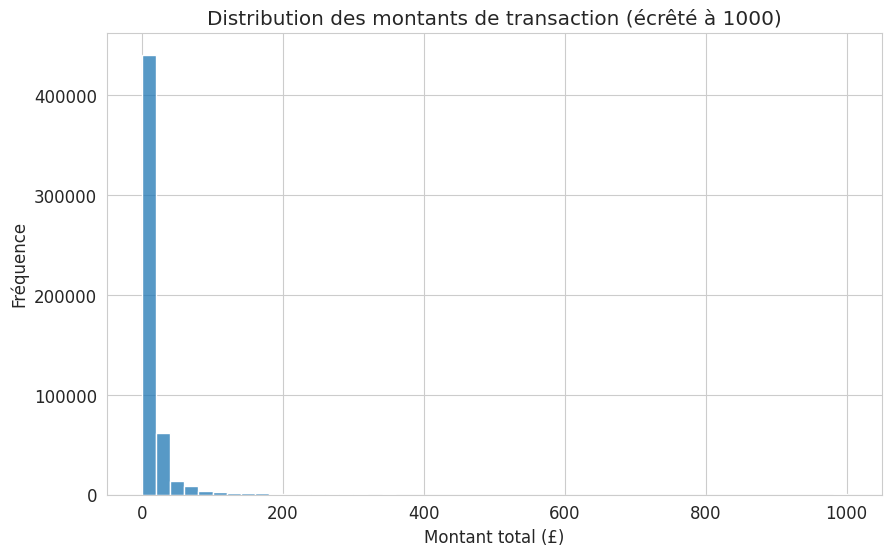

In [ ]:
# Distribution du montant total
plt.figure(figsize=(10, 6))
sns.histplot(pandas_df['TotalAmount'].clip(0, 1000), bins=50)
plt.title('Distribution des montants de transaction (écrêté à 1000)')
plt.xlabel('Montant total (£)')
plt.ylabel('Fréquence')
plt.show()

In [ ]:
# Analyser les ventes quotidiennes
daily_sales = pandas_df.groupby(pandas_df['InvoiceDate'].dt.date).agg(
    revenue=('TotalAmount', 'sum'),
    transactions=('InvoiceNo', 'nunique'),
    unique_customers=('CustomerID', 'nunique')
).reset_index()
daily_sales

,InvoiceDate,revenue,transactions,unique_customers
0,2010-12-01,58635.56,143,98
1,2010-12-02,46207.28,167,117
2,2010-12-03,45620.46,108,55
3,2010-12-05,31383.95,95,76
4,2010-12-06,53860.18,133,90
...,...,...,...,...
300,2011-12-05,57751.32,151,114
301,2011-12-06,54228.37,149,128
302,2011-12-07,75076.22,138,101
303,2011-12-08,81417.78,145,120


from matplotlib import pyplot as plt
daily_sales['revenue'].plot(kind='hist', bins=20, title='revenue')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
daily_sales['transactions'].plot(kind='hist', bins=20, title='transactions')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
daily_sales['unique_customers'].plot(kind='hist', bins=20, title='unique_customers')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
daily_sales.plot(kind='scatter', x='revenue', y='transactions', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
daily_sales.plot(kind='scatter', x='transactions', y='unique_customers', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['InvoiceDate']
  ys = series['revenue']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = daily_sales.sort_values('InvoiceDate', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('InvoiceDate')
_ = plt.ylabel('revenue')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['InvoiceDate']
  ys = series['transactions']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = daily_sales.sort_values('InvoiceDate', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('InvoiceDate')
_ = plt.ylabel('transactions')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['InvoiceDate']
  ys = series['unique_customers']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = daily_sales.sort_values('InvoiceDate', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('InvoiceDate')
_ = plt.ylabel('unique_customers')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['InvoiceDate']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'InvoiceDate'}, axis=1)
              .sort_values('InvoiceDate', ascending=True))
  xs = counted['InvoiceDate']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = daily_sales.sort_values('InvoiceDate', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('InvoiceDate')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
daily_sales['revenue'].plot(kind='line', figsize=(8, 4), title='revenue')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
daily_sales['transactions'].plot(kind='line', figsize=(8, 4), title='transactions')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
daily_sales['unique_customers'].plot(kind='line', figsize=(8, 4), title='unique_customers')
plt.gca().spines[['top', 'right']].set_visible(False)

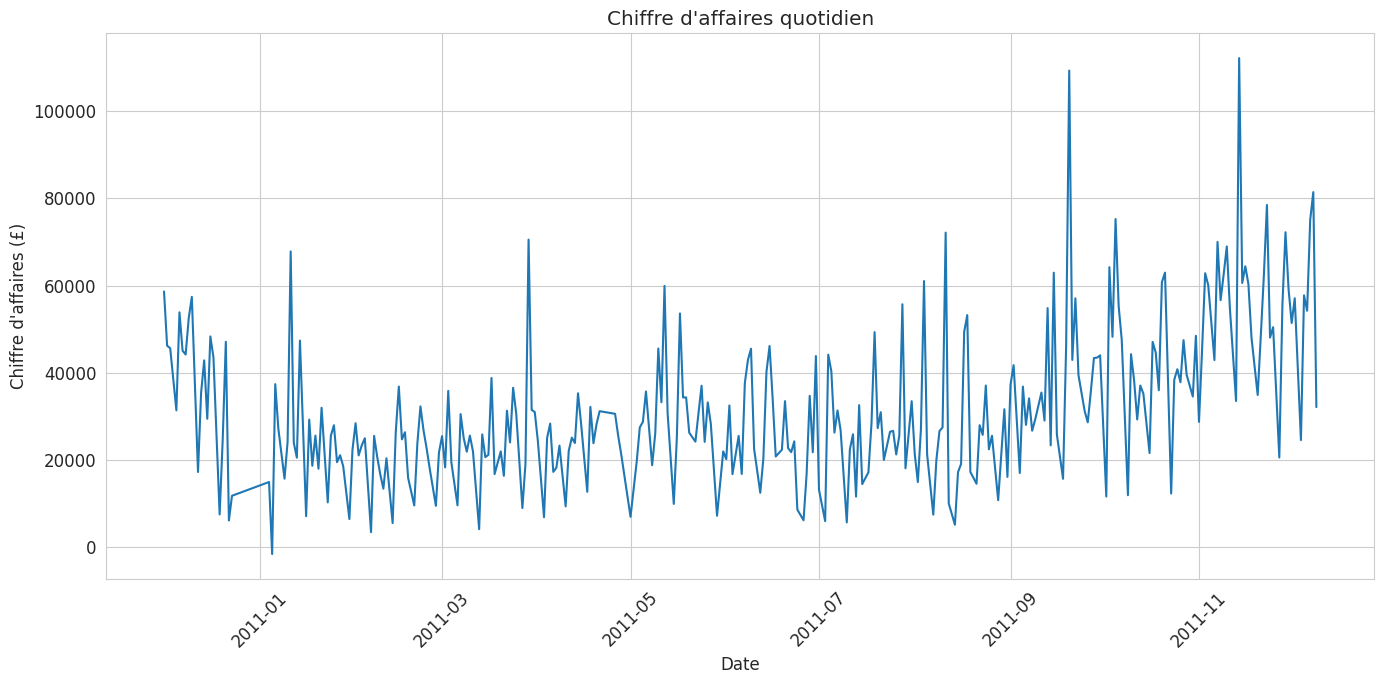

In [ ]:
# Tracer les ventes quotidiennes
plt.figure(figsize=(14, 7))
plt.plot(daily_sales['InvoiceDate'], daily_sales['revenue'])
plt.title('Chiffre d\'affaires quotidien')
plt.xlabel('Date')
plt.ylabel('Chiffre d\'affaires (£)')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

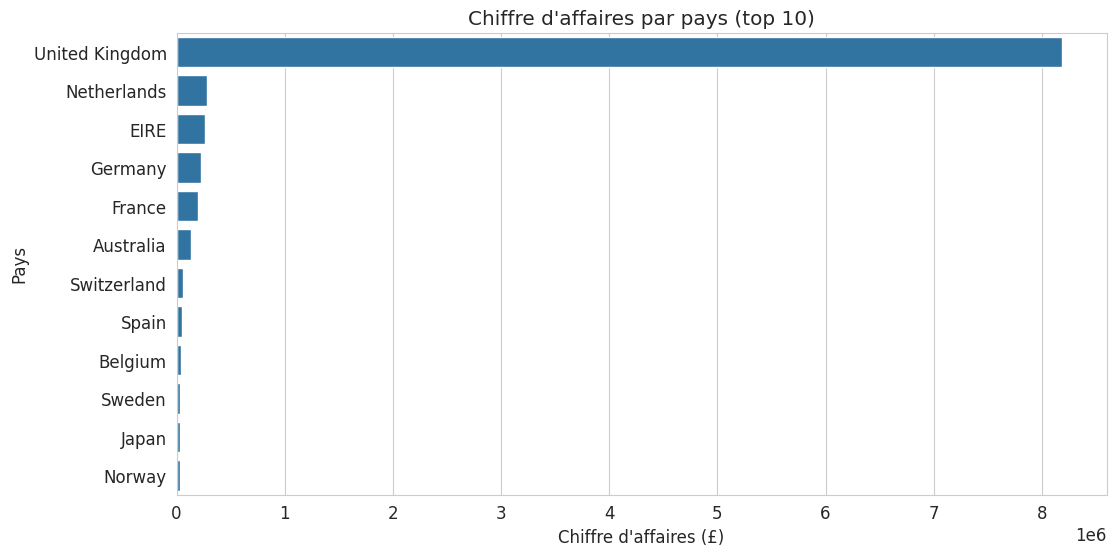

In [ ]:
# Analyser les ventes par pays
country_sales = pandas_df.groupby('Country').agg(
    revenue=('TotalAmount', 'sum'),
    transactions=('InvoiceNo', 'nunique'),
    unique_customers=('CustomerID', 'nunique')
).reset_index().sort_values('revenue', ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(x='revenue', y='Country', data=country_sales.head(12))
plt.title('Chiffre d\'affaires par pays (top 10)')
plt.xlabel('Chiffre d\'affaires (£)')
plt.ylabel('Pays')
plt.show()

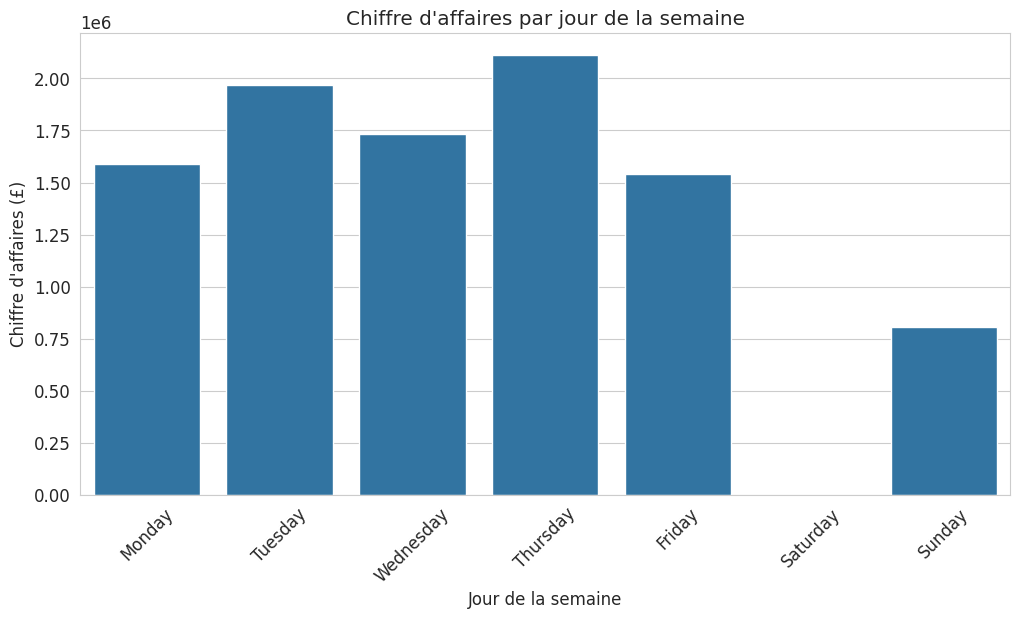

In [ ]:
# Analyser les patterns hebdomadaires
pandas_df['DayOfWeek'] = pandas_df['InvoiceDate'].dt.day_name()
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

weekly_sales = pandas_df.groupby('DayOfWeek').agg(
    revenue=('TotalAmount', 'sum'),
    transactions=('InvoiceNo', 'nunique')
).reindex(day_order).reset_index()

plt.figure(figsize=(12, 6))
sns.barplot(x='DayOfWeek', y='revenue', data=weekly_sales)
plt.title('Chiffre d\'affaires par jour de la semaine')
plt.xlabel('Jour de la semaine')
plt.ylabel('Chiffre d\'affaires (£)')
plt.xticks(rotation=45)
plt.show()

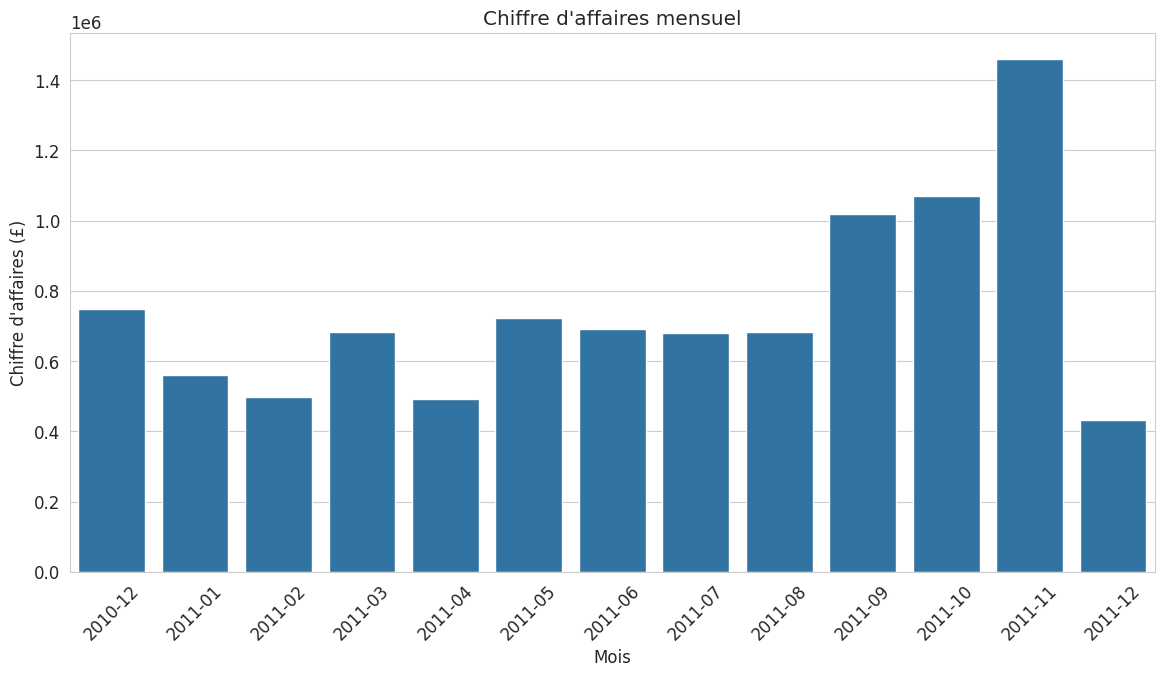

In [ ]:
# Analyser les patterns mensuels
pandas_df['Month'] = pandas_df['InvoiceDate'].dt.strftime('%Y-%m')
monthly_sales = pandas_df.groupby('Month').agg(
    revenue=('TotalAmount', 'sum'),
    transactions=('InvoiceNo', 'nunique'),
    unique_customers=('CustomerID', 'nunique')
).reset_index()

plt.figure(figsize=(14, 7))
sns.barplot(x='Month', y='revenue', data=monthly_sales)
plt.title('Chiffre d\'affaires mensuel')
plt.xlabel('Mois')
plt.ylabel('Chiffre d\'affaires (£)')
plt.xticks(rotation=45)
plt.show()

In [ ]:
# Analyser les retours (quantities < 0)
returns_df = pandas_df[pandas_df['Quantity'] < 0]
print(f"Nombre de lignes avec des quantités négatives (retours): {len(returns_df)}")
print(f"Pourcentage des transactions qui sont des retours: {len(returns_df)/len(pandas_df)*100:.2f}%")


Nombre de lignes avec des quantités négatives (retours): 10624
Pourcentage des transactions qui sont des retours: 1.96%


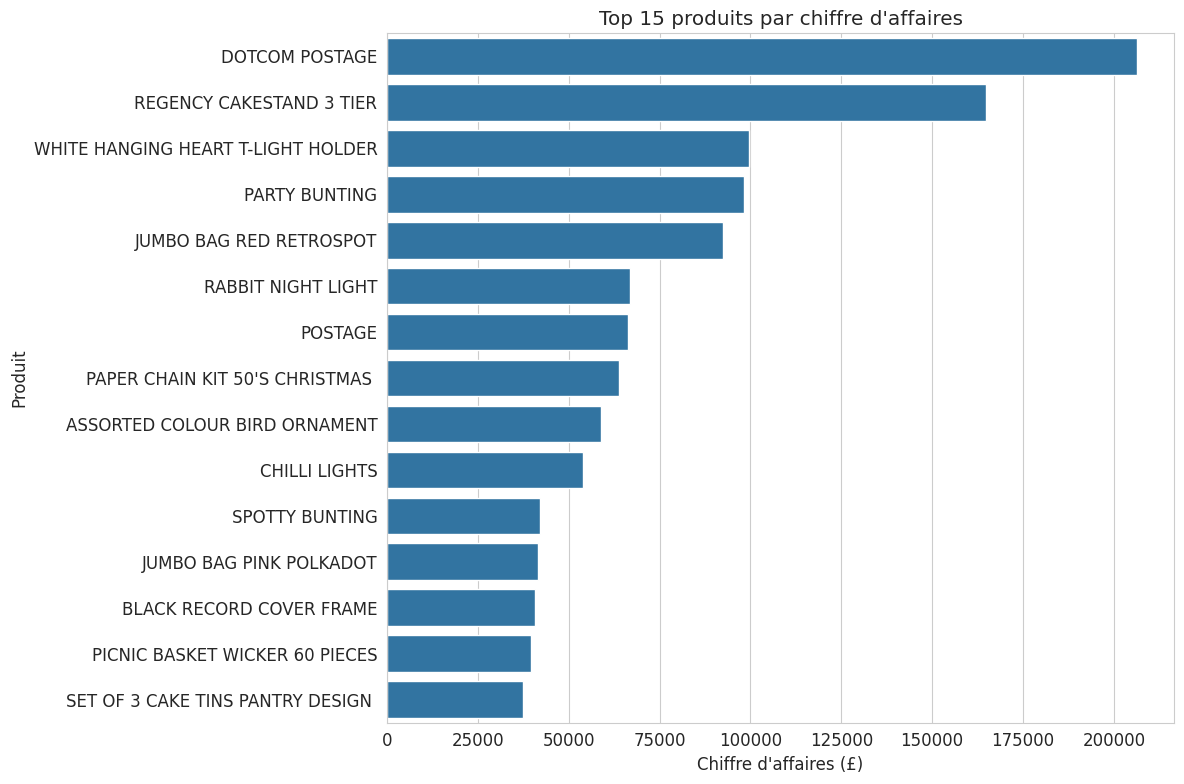

In [ ]:
# Top produits par chiffre d'affaires
product_sales = pandas_df.groupby('Description').agg(
    revenue=('TotalAmount', 'sum'),
    quantity=('Quantity', 'sum'),
    transactions=('InvoiceNo', 'nunique')
).reset_index().sort_values('revenue', ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(x='revenue', y='Description', data=product_sales.head(15))
plt.title('Top 15 produits par chiffre d\'affaires')
plt.xlabel('Chiffre d\'affaires (£)')
plt.ylabel('Produit')
plt.tight_layout()
plt.show()

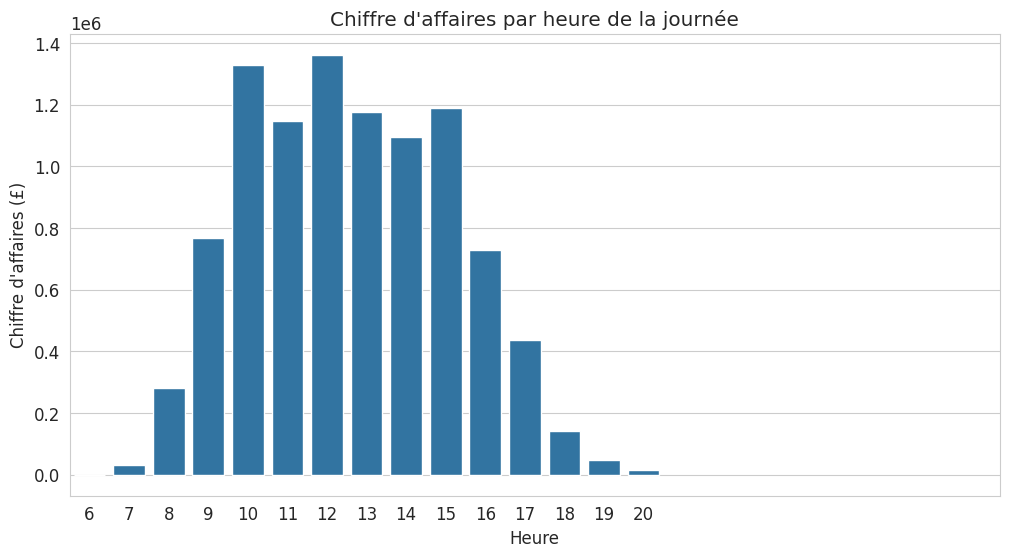

In [ ]:
# Décomposer les ventes par heure de la journée
pandas_df['Hour'] = pandas_df['InvoiceDate'].dt.hour
hourly_sales = pandas_df.groupby('Hour').agg(
    revenue=('TotalAmount', 'sum'),
    transactions=('InvoiceNo', 'nunique')
).reset_index()

plt.figure(figsize=(12, 6))
sns.barplot(x='Hour', y='revenue', data=hourly_sales)
plt.title('Chiffre d\'affaires par heure de la journée')
plt.xlabel('Heure')
plt.ylabel('Chiffre d\'affaires (£)')
plt.xticks(range(24))
plt.show()


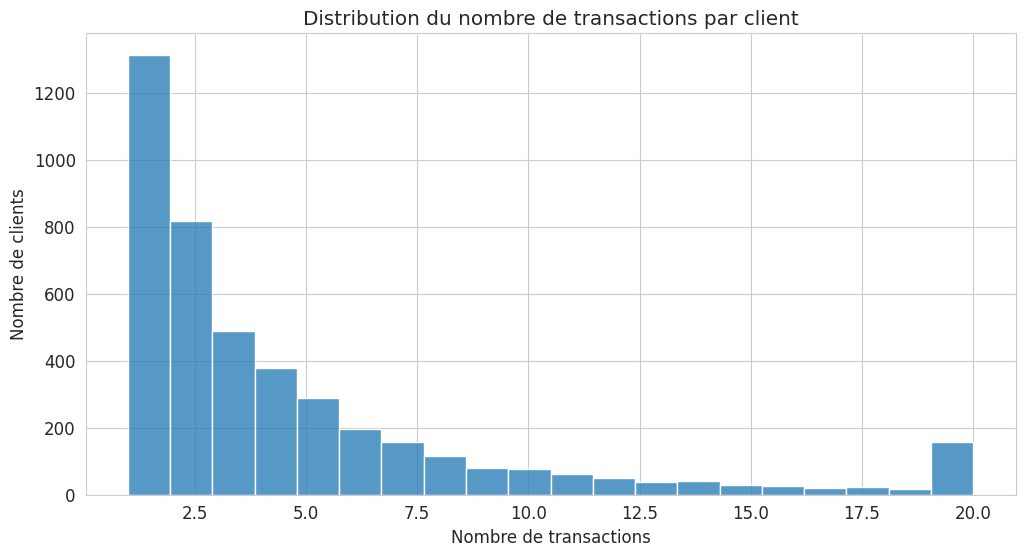

In [ ]:
# Analyser la fréquence d'achat des clients
customer_frequency = pandas_df.groupby('CustomerID').agg(
    num_transactions=('InvoiceNo', 'nunique'),
    total_spend=('TotalAmount', 'sum'),
    first_purchase=('InvoiceDate', 'min'),
    last_purchase=('InvoiceDate', 'max')
).reset_index()

customer_frequency['days_between_purchases'] = (customer_frequency['last_purchase'] - customer_frequency['first_purchase']).dt.days

plt.figure(figsize=(12, 6))
sns.histplot(customer_frequency['num_transactions'].clip(0, 20), bins=20)
plt.title('Distribution du nombre de transactions par client')
plt.xlabel('Nombre de transactions')
plt.ylabel('Nombre de clients')
plt.show()


In [ ]:
!jupyter notebook /content/mmm-ecommerce/notebooks/01_online_retail_exploration.ipynb
# !google.colab.files.view('/content/mmm-ecommerce/notebooks/01_online_retail_exploration.ipynb')

In [ ]:
from google.colab import files
files.view('/content/mmm-ecommerce/notebooks/01_online_retail_exploration.ipynb')

In [ ]:
# Ajouter tous les fichiers
!git add .

# Faire un commit avec un message explicite
!git commit -m "Finalisation du projet MMM avec adaptation pour les données Online Retail de Kaggle"

# Pousser vers GitHub
!git push origin master